### Visualizing GeoJSON from WeatherRoutingTool

#### Import the necessary libraries

In [3]:
import sqlalchemy as db
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape,box,Polygon

#### Create sqlalchemy engine and connect to the postgis using database credentials

In [4]:
con1 = db.create_engine("postgresql://{user}:{pwd}@{host}:{port}/{db}".format(user='postgres-user', pwd='postgres-password', host='host',
                                                                  db='database', port=5432))
df = pd.read_sql(con=con1,sql="select * from weather_routing_job")
df.head(2)

,id,jobid,status,result,details,end_time,request,start_time
0,460,2eb66718-c66b-4537-a989-5e198f8e089d,IN_PROCESS,None,Job is being processed,NaT,"{'eta': '2023-08-23T12:00Z', 'etd': '2023-08-2...",2023-08-28 12:54:23.459400+00:00
1,466,0e90a4fc-9789-4f3a-8bac-ccf37839c1a4,FAILED,None,Job failed to process: index 0 is out of bound...,2023-08-28 15:00:48.261669+00:00,"{'eta': '2023-08-27T12:00Z', 'etd': '2023-08-2...",2023-08-28 14:14:45.417039+00:00


#### Filter existing NaN values in result

In [16]:
list_geom= list(df['result'].dropna())
list_geom[-1]

{'type': 'FeatureCollection',
 'features': [{'id': 0,
   'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-0.055477, 50.290091]},
   'properties': {'time': '2023-10-09 12:00:00',
    'speed': {'unit': 'm/s', 'value': '6'},
    'fuel_type': 'HFO',
    'engine_power': {'unit': 'kW', 'value': 2714.580117628123},
    'fuel_consumption': {'unit': 'mt/h', 'value': 0.651436326622936},
    'propeller_revolution': {'unit': 'Hz', 'value': 67.65820757599978}}},
  {'id': 1,
   'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [0.3080744807874248, 50.34200762424825]},
   'properties': {'time': '2023-10-09 13:13:41',
    'speed': {'unit': 'm/s', 'value': '6'},
    'fuel_type': 'HFO',
    'engine_power': {'unit': 'kW', 'value': 2736.230731088982},
    'fuel_consumption': {'unit': 'mt/h', 'value': 0.6578346276838739},
    'propeller_revolution': {'unit': 'Hz', 'value': 67.46661955804592}}},
  {'id': 2,
   'type': 'Feature',
   'geometry': {'type': 'Point',
    '

#### serialize a Python object (dictionary) into a JSON string.

In [6]:
import json
dic = json.dumps(list_geom[-1])

#### visualize the GeoJSON using geopandas explore method

In [7]:
gdf =gpd.read_file(dic,driver='GeoJSON')
# gdf['time'] = gdf['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf['time'] = gdf['time'].astype(str)
gdf.explore()

#### check the properties of each point geometries as a dictionary

In [11]:
for i,v in gdf.iterrows():
    print(dict(v))


{'time': '2023-10-09 12:00:00', 'speed': {'unit': 'm/s', 'value': '6'}, 'fuel_type': 'HFO', 'engine_power': {'unit': 'kW', 'value': 2714.580117628123}, 'fuel_consumption': {'unit': 'mt/h', 'value': 0.651436326622936}, 'propeller_revolution': {'unit': 'Hz', 'value': 67.65820757599978}, 'geometry': <POINT (-0.055 50.29)>}
{'time': '2023-10-09 13:13:41', 'speed': {'unit': 'm/s', 'value': '6'}, 'fuel_type': 'HFO', 'engine_power': {'unit': 'kW', 'value': 2736.230731088982}, 'fuel_consumption': {'unit': 'mt/h', 'value': 0.6578346276838739}, 'propeller_revolution': {'unit': 'Hz', 'value': 67.46661955804592}, 'geometry': <POINT (0.308 50.342)>}
{'time': '2023-10-09 14:26:39', 'speed': {'unit': 'm/s', 'value': '6'}, 'fuel_type': 'HFO', 'engine_power': {'unit': 'kW', 'value': 2969.60326206016}, 'fuel_consumption': {'unit': 'mt/h', 'value': 0.7261724659606658}, 'propeller_revolution': {'unit': 'Hz', 'value': 69.87263588656089}, 'geometry': <POINT (0.662 50.41)>}
{'time': '2023-10-09 15:32:46', 's

#### calculate mean of x-coordinates from all geometries

In [12]:
gdf["geometry"].values.x.mean()

0.999511959347704

#### visualize the geometrical objects in folium map

In [13]:
import folium
import folium.plugins

# Creating a map centered on Germany with a zoom level of 6
# map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Creating a map centered around mean geometry with a zoom level of 6
map = folium.Map(
    location=[gdf["geometry"].values.y.mean(), gdf["geometry"].values.x.mean()],
    zoom_start=6,
)

# Add basemaps
basemap1 = folium.TileLayer("OpenStreetMap").add_to(map)
basemap2 = folium.TileLayer("Stamen Terrain").add_to(map)
basemap3 = folium.TileLayer("Stamen Toner").add_to(map)
basemap4 = folium.TileLayer("Stamen Watercolor").add_to(map)
basemap5 = folium.TileLayer(
    "http://tiles.openseamap.org/seamark/{z}/{x}/{y}.png",
    name="OpenSeaMap",
    attr="Map data © OpenSeaMap contributors",
).add_to(map)

# Adding the point geometries as a marker
for i, element in gdf.iterrows():
    lat = element[-1].y
    lon = element[-1].x
    folium.Marker(
        location=[lat, lon],
        popup=f"<b>{dict(element[:-1])}, 'lat': {lat} , 'lon': {lon}</b>",
        tooltip=f"<b>{dict(element[:-1])},lat: {lat} , lon:{lon}</b>",
        icon=folium.Icon(color="gray"),
    ).add_to(map)


# Create a layer control
folium.LayerControl().add_to(map)

# add multiple leaflet plugins
folium.LatLngPopup().add_to(map)                    # popup latitude, longitude on mouseclick
folium.plugins.MousePosition().add_to(map)          # gives mouse position on map
folium.plugins.Geocoder().add_to(map)               # find location based on names
folium.plugins.MeasureControl(
    position="topright",
    primary_length_unit="meters",
    secondary_length_unit="miles",
    primary_area_unit="sqmeters",
    secondary_area_unit="acres",
).add_to(
    map
)  # measure distance and areas
folium.plugins.MiniMap(position="bottomleft").add_to(map)  # location overview map
draw = folium.plugins.Draw(                                # draw control for geometries and geojson export
    export=True,
    filename="data.geojson",
    position="topleft",
    draw_options={"polyline": {"allowIntersection": False}},
    edit_options={"poly": {"allowIntersection": False}},
)

# add draw control as a child to the map
map.add_child(draw)
# folium.LayerControl().add_to(map)

map

### 

In [ ]:
gdf_list=[]
for geo in list_geom:   
    gdf =gpd.read_file(geo,driver='GeoJSON')
    gdf_list.append(gdf)

In [30]:
con = db.create_engine("postgresql://{user}:{pwd}@{host}:{port}/{db}".format(user='postgres-user', pwd='postgres-password', host='host',
                                                                  db='database', port=5432))

In [26]:
from shapely import GeometryCollection

In [ ]:
from shapely.geometry import shape,collection
# from geojson import 
GeometryCollection(list_geom)


In [ ]:
gdf_seamark = gpd.read_postgis(con=con,sql="select * from openseamap.nodes LIMIT 100")
gdf_seamark

In [7]:
list_new= [[[], []],[[], []],[[], []],[[], []]]

all_empty1 = all(lis== [[],[]] for lis in list_new)
all_empty1

True

In [9]:
list_of_sublists = [[], [], [[],[]]]

# Check if all sublists are empty
all_empty = all(sublist==[] or [[],[]] for sublist in list_of_sublists)
all_empty

True

#### checking the shapely predicates 

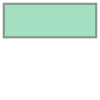

In [1]:
from shapely.geometry import box,LineString
from shapely.strtree import STRtree
import pandas
import geopandas as gpd
import sqlalchemy as db

bbox= box(-0.9448242187500001,50.00067775723633,2.6806640625,51.32031367286625)

bbox

In [7]:
line =LineString([[-8.250732,48.973006], [-12.128906,45.614037]])

In [ ]:
gdf_box = gpd.GeoDataFrame(geometry=[bbox,line],crs="epsg:4326")
gdf_box.explore()

In [ ]:
gdf_line = gpd.GeoDataFrame(geometry=[line],crs="epsg:4326")
gdf_line.explore()

In [11]:
tree = STRtree(gdf_box['geometry'])
tree


In [12]:
tree.query(line, predicate='intersects').tolist()

[]

In [35]:

predicates_list= ["intersects", "contains", "touches", "crosses", "overlaps"]
geom_object_list = []
for predicate in predicates_list:
    geom_object = tree.query(gdf_line["geometry"], predicate=predicate).tolist()
    geom_object_list.append(geom_object)

# checks if there is spatial relation between routes and seamarks objects
# if geom_object == [[], []] or geom_object == []:
all(sublist == [[],[]] for sublist in geom_object_list) or all(sublist == [] for sublist in geom_object_list)

In [ ]:
if all_empty:
    print("All sublists are empty.")
else:
    print("At least one sublist is not empty.")